In [1]:
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cmocean as cmo
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy as np
import copy

In [36]:
run = 'n011'

fnames = sorted(glob.glob(f'../data/ecefiles/{run}/{run}*.nc'))

year0 = np.array([int(fname[-27:-23]) for fname in fnames])
year1 = np.array([int(fname[-18:-14]) for fname in fnames])
nyears = sum(year1+1-year0)

basin = np.arange(0,5)
bnames = ['EAIS','ROSS','AMUN','WEDD','PENS']
bcol = ['tab:blue','tab:orange','tab:red','tab:purple','tab:green']
rean = np.array([0.5,-0.3,1.4,-0.8,-0.2]) #From Eveline
cmip6 = rean+[.06,.71,1.17,-.57,-.33] #From Eveline

In [3]:
#Get time-independent variables
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()

ds = xr.open_dataset(fnames[0])
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
levmid = ds['olevel'].values
lev = ds['olevel_bounds'].values
time_bnds = ds['time_centered_bounds']
thick = ds['e3t'].values #Quasi-time-independent, treated as fixed
ds.close()
secs = (time_bnds[:,1]-time_bnds[:,0]).values / np.timedelta64(1, 's')

In [4]:
#Get weighted mask for basin averages
lons = np.repeat(lon[np.newaxis,:,:],len(levmid),axis=0)
lats = np.repeat(lat[np.newaxis,:,:],len(levmid),axis=0)
mask = np.repeat(np.zeros(lons.shape)[np.newaxis,:,:,:],len(basin),axis=0)
aweight = np.zeros(mask.shape)

for b,bb in enumerate(basin):
    mm = np.zeros(lons.shape)
    if b==0:
        #EAIS
        mm[((lons<173) & (lons>-10)) & (lats<-65) & (lats>-76)] = 1
        depp = 369
    if b==1:
        #ROSS
        mm[((lons>150) | (lons<-150)) & (lats<-76)] = 1
        depp = 312        
    if b==2:
        #AMUN
        mm[(lons>-150) & (lons<-80) & (lats<-70)] = 1
        depp = 305
    if b==3:
        #WEDD
        mm[(lons>-65) & (lons<-10) & (lats<-72)] = 1
        depp = 420
    if b==4:
        #APEN
        mm[(lons>-66) & (lons<-56) & (lats>-70) & (lats<-65)] = 1
        mm[(lons>-80) & (lons<-65) & (lats>-75) & (lats<-70)] = 1
        depp = 420
        
    z0 = depp-100.
    i0 = np.argmax(lev[:,1]>z0)
    mm[:i0,:,:] = 0
    w0 = (lev[i0,1]-z0)/(lev[i0,1]-lev[i0,0])
    mm[i0,:,:] = w0*mm[i0,:,:]
    for j in range(0,lon.shape[0]):
        for i in range(0,lon.shape[1]):
            if np.nansum(thick[0,i0:,j,i]) == 0:
                continue
            z1 = depp+100.
            i1 = np.argmin(lev[:,1]<z1)
            w1 = (z1-lev[i1,0])/(lev[i1,1]-lev[i1,0])
            mm[i1,j,i] = w1*mm[i1,j,i]
            mm[i1+1:,j,i] = 0
    mask[b,:,:,:] = mm*np.where(np.isnan(thick[0,:,:,:]),0,thick[0,:,:,:])/200.
    aweight[b,:,:,:] = mask[b,:,:,:]*area[np.newaxis,:,:] 

In [5]:
#Calculate basin-average annual time series
tbas = np.zeros((len(basin),nyears))
ttime = np.arange(nyears)
months = np.arange(0,12)

c = 0
for f,fname in enumerate(fnames):
    ds = xr.open_dataset(fname)
    time = ds['time_centered'].values
    temp = ds['thetao'].values
    ds.close()
    
    year0 = int(fname[-27:-23])
    
    tb = np.zeros((len(basin)))
    ny = int(len(time)/12)
    for y in np.arange(0,ny):
        for b,bb in enumerate(bnames):
            for m,mm in enumerate(months):
                tbb = np.nansum(temp[m+12*y,:,:,:]*aweight[b,:,:,:])/np.nansum(aweight[b,:,:,:])
                tb[b] += tbb*secs[m]
            tbas[b,c] = tb[b]/sum(secs)
        print(year0+y,c,tbas[:,c])
        tb = np.zeros((len(basin)))
        c += 1

ttime2 = ttime
tbas2 = tbas

1850 0 [ 0.25193966  1.35673781  2.40433786 -1.50577199  0.12984292]
1851 1 [ 0.22354953  1.63699365  2.48575935 -1.47730729  0.21272299]
1852 2 [ 0.23286715  1.40220394  2.51479127 -1.50706805  0.17239681]
1853 3 [ 0.2593282   1.29979571  2.52768134 -1.5629772   0.09274458]
1854 4 [ 0.21065907  1.34952798  2.52167665 -1.57909392  0.05312205]
1855 5 [ 0.14990851  1.6206352   2.49392156 -1.51907911 -0.07516993]
1856 6 [ 0.23728455  1.74700525  2.43910805 -1.45895526 -0.0858355 ]
1857 7 [ 0.29520509  1.36762624  2.46447814 -1.4538988  -0.07749244]
1858 8 [ 0.35617915  1.4083121   2.42530183 -1.43881187 -0.20101286]
1859 9 [ 0.46814568  1.41318327  2.37931505 -1.34979145 -0.28297246]
1860 10 [ 0.53020445  1.44342186  2.309411   -1.21105221 -0.2918838 ]
1861 11 [ 0.59455589  1.3618874   2.27937403 -1.10461075 -0.18828993]
1862 12 [ 0.57626801  1.04710292  2.23732273 -1.12925956 -0.15094726]
1863 13 [ 0.54831404  0.74909489  2.2236054  -1.16284443 -0.21072927]
1864 14 [ 0.48963065  0.806049

In [10]:
ttime = ttime2[:-4]
tbas = tbas2[:,:-4]

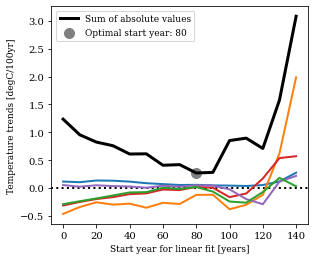

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

startyears = np.arange(0,len(ttime)-40,10)

ax.axhline(0,0,1,c='k',ls=':')

for b,bb in enumerate(bnames):
    nettrend = np.zeros(len(startyears))
    for s,startyear in enumerate(startyears):
        nettrend[s] = 100*np.polyfit(ttime[startyear:],tbas[b,startyear:],1)[0]
    ax.plot(startyears,nettrend,c=bcol[b])    

    
nettrend = np.zeros(len(startyears))

for s,startyear in enumerate(startyears):
    fits = np.zeros(len(bnames))
    for b,bb in enumerate(bnames):
        fits[b] = 100*np.polyfit(ttime[startyear:],tbas[b,startyear:],1)[0]
    nettrend[s] = sum(np.abs(fits))

optyear = startyears[np.argmin(nettrend)]
ax.plot(startyears,nettrend,c='k',lw=3,label='Sum of absolute values')
ax.scatter(optyear,np.min(nettrend),100,marker='o',c='.5',label=f'Optimal start year: {optyear}')
ax.legend()
ax.set_ylabel('Temperature trends [degC/100yr]')
ax.set_xlabel('Start year for linear fit [years]')
plt.savefig(f'../figures/picontrol_trends.png',dpi=450)
plt.show()

In [12]:
mpl.rcParams['lines.linewidth'] = 2.
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['figure.subplot.wspace'] = .1
mpl.rcParams['figure.subplot.left'] = .1
mpl.rcParams['figure.subplot.right'] = .99
mpl.rcParams['figure.figsize'] = (7,4)

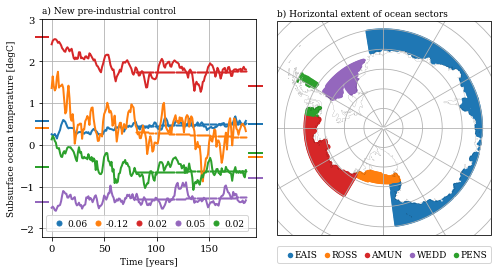

In [41]:
startyear = optyear
#startyear = 60

fig = plt.figure()

ax = fig.add_subplot(121)
for b,bb in enumerate(bnames):
    ax.plot(ttime,tbas[b,:],c=bcol[b])
    fit = np.polyfit(ttime[startyear:],tbas[b,startyear:],1)
    plt.scatter(ttime[startyear:],fit[0]*ttime[startyear:]+fit[1],1,c=bcol[b],label=f'{100*fit[0]:.2f}')
    plt.axhline(rean[b],.97,1.03,c=bcol[b],lw=2,clip_on=False)
    plt.axhline(cmip6[b],-.03,.03,c=bcol[b],lw=2,clip_on=False)
    
ax.legend(bbox_to_anchor=(0,.12),loc='upper left',ncol=5,markerscale=5,columnspacing=.15,handletextpad=-.1)

ax.set_title('a) New pre-industrial control',loc='left')
ax.set_ylabel('Subsurface ocean temperature [degC]')
ax.set_xlabel('Time [years]')
ax.grid(True)
#ax.set_xlim([ttime[0],ttime[-1]])
ax.set_ylim([-2.2,3])

ax = fig.add_subplot(122,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -63], crs=ccrs.PlateCarree())
for b,bb in enumerate(bnames):
    im = ax.scatter(lon,lat,15*np.nansum(mask[b,:,:,:],axis=0),c=bcol[b],transform=ccrs.PlateCarree(),label=bb,lw=0,alpha=1)
ax.coastlines(lw=.1)
ax.set_title('b) Horizontal extent of ocean sectors',loc='left')
ax.legend(bbox_to_anchor=(-.02,-.15),loc='lower left',ncol=5,markerscale=2,columnspacing=.05,handletextpad=-.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-180,210,30))
gl.xformatter = LONGITUDE_FORMATTER

plt.savefig(f'../draftfigs/ts_temp_{run}.png',dpi=450)
plt.show()